# Hyperparameter Tuning - Model Deployment - Inference

**This notebook outlines a project focused on object detection utilizing SageMaker. It demonstrates the entire process starting from setting up the environment, bucket creation, uploading training and test data to S3, to model training with hyperparameter tuning, and finally, deployment and testing of the model**

### Bucket Creation

In [2]:
import boto3
import json
import random
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg
import os
import glob
import sagemaker
from sagemaker import get_execution_role
from sagemaker import image_uris
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.debugger import Rule, rule_configs, ProfilerRule

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [27]:
s3 = boto3.resource('s3', region_name='us-east-2')
role = get_execution_role()
session = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


#### Environment Variables and Data Uploading

In [4]:
bucket_name = "airplane-object-detection-project"
prefix = "object-detection"

train_channel = "model/rec_files/train"
validation_channel = "model/rec_files/validation"

In [5]:
# Uploading train .rec file to S3
session.upload_data(path="train.rec", bucket = bucket_name, key_prefix = train_channel)
s3_train_data = "s3://{}/{}".format(bucket_name, train_channel)

s3_train_data

's3://airplane-object-detection-project/model/rec_files/train'

In [6]:
# Uploading test .rec file to S3
session.upload_data(path="test.rec", bucket = bucket_name, key_prefix = validation_channel)
s3_validation_data = "s3://{}/{}".format(bucket_name, validation_channel)

s3_validation_data

's3://airplane-object-detection-project/model/rec_files/validation'

### Object Detection Algorithm Downloading

In [19]:
# Creation folder to save the image
s3_output_location = "s3://airplane-object-detection-project/model/model_output"
s3_output_location

's3://airplane-object-detection-project/model/model_output'

In [20]:
# Retrieving the image
training_image = image_uris.retrieve(region = session.boto_region_name, 
                                     framework = "object-detection", 
                                     version = "1")
training_image

'825641698319.dkr.ecr.us-east-2.amazonaws.com/object-detection:1'

## Hyperparameter Tuning

- **Learning Rate (0.001 to 0.1):**
   - Chosen to explore a common range for learning rates, ensuring the model can learn at varying speeds. The lower bound allows the model to learn slowly, possibly achieving a more refined and accurate model, while the upper bound allows for faster learning which could be beneficial in cases where the optimal solution is easy to find.

- **Mini Batch Size (8, 16):**
   - These values were selected to explore the trade-off between the computational efficiency and model’s ability to generalize. A smaller batch size may offer more robust convergence properties and generalization, while a larger batch size allows for computational efficiencies due to optimized matrix operations and parallelization capabilities.

- **Optimizer (SGD, Adam):**
   - These are two widely used optimization algorithms in training deep learning models. SGD is known for its robustness and efficiency, and Adam is recognized for its effective adaptive learning rate properties, allowing the exploration of the benefits of both momentum and adaptive learning rates during the tuning process.

- **Epochs (50, 60, 70, 80, 95):**
   - These values were chosen to give the model ample opportunity to learn from the data iteratively and converge while preventing potential overfitting. Different epoch values allow us to observe the model performance at various points in the learning process, helping in understanding the learning dynamics and identifying the most suitable training duration for the model.

- **Max Jobs (6):**
   - This was selected to ensure a broad exploration of the hyperparameter space, allowing multiple training jobs with different hyperparameter combinations. It allows for a balance between gaining insights and managing computational resources and costs effectively.

- **Max Parallel Jobs (1):**
   - Set to one to execute training jobs sequentially, ensuring that the computational resources are not overwhelmed by running multiple training jobs simultaneously. This setting aids in maintaining system stability and avoiding potential resource contention, leading to more reliable training job outcomes.

- **Early Stopping Rule (60 Steps):**
   - Implemented to monitor the model's training process and stop the training if the loss does not decrease for 60 consecutive evaluations, ensuring a minimum of 2 epochs are run. This helps in preventing unnecessary computations and possible overfitting when the model is not improving, contributing to more efficient resource usage and potentially better model generalization.

These ranges and values are chosen based on common practices and empirical evidence from the literature and previous experiments, ensuring a balance between explorative capability and computational efficiency.


### Setting our Estimator

In [13]:
# Defining early stops rules
early_stopping_rule = Rule.sagemaker(
    base_config=rule_configs.loss_not_decreasing(),
    rule_parameters={
        "collection_names": "metrics",
        "num_steps": "60", # The training will stop if the loss doesn’t decrease for 60 consecutive evaluations, 
                            #ensuring a minimum of 2 epochs are run.
    },
)

profiler_rule = ProfilerRule.sagemaker(rule_configs.ProfilerReport())


od_model = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count = 1,
    instance_type = "ml.p3.2xlarge",
    volume_size=50,
    max_run = 360000,
    input_mode = "File",
    output_path = s3_output_location,
    sagemaker_session= session,
    rules=[early_stopping_rule,profiler_rule] 
)

od_model

In [14]:
# Check the amount of images for training and test

folder_train = glob.glob("airplane_detection/images/airplanes/images/train/*.jpg")
folder_test = glob.glob("airplane_detection/images/airplanes/images/test/*.jpg")

len(folder_train), len(folder_test)

(1546, 520)

### Setting Hyperparameters and Tuner

In [15]:
# Function to set hyperparameters
def set_hp(n_epochs, lr_steps):
    n_classes = 1  # number of classes we want to predict
    n_training_samples = 1546 # number of images to train
    
    od_model.set_hyperparameters(
        base_network = "resnet-50",
        use_pretrained_model = 1,
        num_classes = n_classes,
        epochs = n_epochs,
        lr_scheduler_step = lr_steps,
        lr_scheduler_factor = 0.1,
        momentum = 0.9,
        weight_decay = 0.0005, # preventing overfitting
        nms_threshold = 0.45, # threshold for low convidence detections
        image_shape = 512,
        num_training_samples = n_training_samples    
    )
    
set_hp(100, "50,70,80,90,95")

In [16]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "mini_batch_size": CategoricalParameter([8, 16]),
    "optimizer": CategoricalParameter(["sgd","adam"])
}

In [17]:
tuner = HyperparameterTuner(estimator = od_model,
                            objective_metric_name = "validation:mAP", # Setting our metric in test (test = validation in SM)
                            hyperparameter_ranges = hyperparameter_ranges,
                            objective_type = "Maximize", # Objective in Object Detection
                            max_jobs = 6, # Training jobs max
                            max_parallel_jobs = 1 # Sequential jobs
                           )

In [19]:
s3_train_data, s3_validation_data

('s3://airplane-object-detection-project/model/rec_files/train',
 's3://airplane-object-detection-project/model/rec_files/validation')

#### Setting Channels

In [20]:
train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution = "FullyReplicated",
    content_type = "application/x-recordio",
    s3_data_type = "S3Prefix"
)


validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_data,
    distribution = "FullyReplicated",
    content_type = "application/x-recordio",
    s3_data_type = "S3Prefix"
)

data_channels = {"train": train_data, "validation": validation_data}

In [ ]:
tuner.fit(inputs = data_channels, logs = True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Hyperparameter Results

In [3]:
import sagemaker
from sagemaker import HyperparameterTuningJobAnalytics
session = sagemaker.Session()


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [4]:
tuning_job_name = 'object-detection-231007-1859'
tuning_job_analysis = HyperparameterTuningJobAnalytics(tuning_job_name)
df = tuning_job_analysis.dataframe()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [6]:
# List of training jobs and results
df

,learning_rate,mini_batch_size,optimizer,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.100000,8.0,sgd,object-detection-231007-1859-006-6e7f464d,Completed,0.000527,2023-10-08 04:51:02+00:00,2023-10-08 06:51:55+00:00,7253.0
1,0.006489,8.0,sgd,object-detection-231007-1859-005-8923062a,Completed,0.400602,2023-10-08 02:42:07+00:00,2023-10-08 04:48:31+00:00,7584.0
2,0.015592,16.0,sgd,object-detection-231007-1859-004-ce692836,Completed,0.404084,2023-10-08 00:51:33+00:00,2023-10-08 02:33:11+00:00,6098.0
3,0.003661,16.0,sgd,object-detection-231007-1859-003-b005d6f5,Completed,0.397920,2023-10-07 23:01:14+00:00,2023-10-08 00:43:58+00:00,6164.0
4,0.024009,8.0,adam,object-detection-231007-1859-002-eb707769,Completed,0.045820,2023-10-07 20:50:58+00:00,2023-10-07 22:51:55+00:00,7257.0
5,0.069350,16.0,adam,object-detection-231007-1859-001-6adfa61c,Completed,0.027924,2023-10-07 19:00:44+00:00,2023-10-07 20:39:52+00:00,5948.0


In [8]:
# Best training job
sagemaker_client = boto3.client('sagemaker')

tuning_job_info = sagemaker_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

best_training_job = tuning_job_info['BestTrainingJob']
best_job_name = best_training_job['TrainingJobName']
print(f"Best training job name: {best_job_name}")

Best training job name: object-detection-231007-1859-004-ce692836


In [18]:
import pandas as pd

best_training_job_description = sagemaker_client.describe_training_job(
    TrainingJobName=best_job_name
)

training_metrics = best_training_job_description['FinalMetricDataList']
metrics_df = pd.DataFrame({
    'MetricName': [metric['MetricName'] for metric in training_metrics],
    'Value': [metric['Value'] for metric in training_metrics]
})

hyperparameters = best_training_job_description['HyperParameters']
hyperparameters_df = pd.DataFrame(list(hyperparameters.items()), columns=['HyperParameter', 'Value'])

# Metrics
display(metrics_df.transpose())

,0,1,2,3,4
MetricName,train:progress,train:smooth_l1,train:cross_entropy,validation:mAP,ObjectiveMetric
Value,100.0,0.259656,0.523478,0.404084,0.404084


In [17]:
# Hyperparameters
display(hyperparameters_df)

,HyperParameter,Value
0,_tuning_objective_metric,validation:mAP
1,base_network,resnet-50
2,epochs,100
3,image_shape,512
4,learning_rate,0.015591662535987936
5,lr_scheduler_factor,0.1
6,lr_scheduler_step,"50,70,80,90,95"
7,mini_batch_size,16
8,momentum,0.9
9,nms_threshold,0.45


The top-performing model achieved a Final Objective Metric Value (mAP) of 0.404084, indicating its ability to detect airplanes with considerable accuracy.

## Model Deployment

In [35]:
runtime = boto3.client(service_name = "runtime.sagemaker")

In [31]:
# Model artifact location in S3
best_model = f"s3://airplane-object-detection-project/model/model_output/object-detection-231007-1859-004-ce692836/output/model.tar.gz"
best_model

's3://airplane-object-detection-project/model/model_output/object-detection-231007-1859-004-ce692836/output/model.tar.gz'

In [32]:
model = sagemaker.model.Model(
    image_uri = training_image,
    model_data = best_model,
    role = role) 

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [ ]:
endpoint_name = "airplane-detection-endpoint"

deploy_model = model.deploy(
    initial_instance_count = 1,
    instance_type = "ml.m4.xlarge",
    endpoint_name = endpoint_name)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
-------------!

## Testing our endpoint

In [49]:
# Test images
img_1 = "airplane_detection/images/airplanes/images/validation/0001eeaf4aed83f9.jpg"
img_2 = "airplane_detection/images/airplanes/images/validation/0009bad4d8539bb4.jpg"
img_3 = "airplane_detection/images/airplanes/images/validation/0019e544c79847f5.jpg"
img_4 = "airplane_detection/images/airplanes/images/validation/007384da2ed0464f.jpg"


test_images = [img_1, img_2, img_3, img_4]

In [65]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import json

def draw_bounding_boxes(image_file, detections, threshold=0.2):
    image = mpimg.imread(image_file)
    plt.imshow(image)
    
    image_height, image_width = image.shape[:2]
    assigned_colors = dict()

    valid_detections = [d for d in detections if d[1] >= threshold]

    if not valid_detections:
        plt.show()
        return

    detection = valid_detections[0]
    klass, score, x0, y0, x1, y1 = detection
    class_id = int(klass)
    
    if class_id not in assigned_colors:
        assigned_colors[class_id] = (0,0,1)
            
    xmin = int(x0 * image_width)
    ymin = int(y0 * image_height)
    xmax = int(x1 * image_width)
    ymax = int(y1 * image_height)
    
    bounding_box = plt.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        fill=False,
        edgecolor=assigned_colors[class_id],
        linewidth=2.5
    )
    
    plt.gca().add_patch(bounding_box)
    plt.gca().text(
        xmin,
        ymin - 2,
        "{:.3f}".format(score),
        bbox=dict(facecolor=(1, 0, 0, 1), alpha=0.5),
        color="white"
    )
    
    plt.show()

def predict_and_show(image_filename, endpoint_name, threshold=0.3):
    with open(image_filename, "rb") as image:
        image_byte_array = bytearray(image.read())
    
    response = runtime.invoke_endpoint(
        EndpointName=endpoint_name, 
        ContentType="image/jpeg", 
        Body=image_byte_array
    )
    
    results = json.loads(response["Body"].read())
    draw_bounding_boxes(image_filename, results["prediction"], threshold)


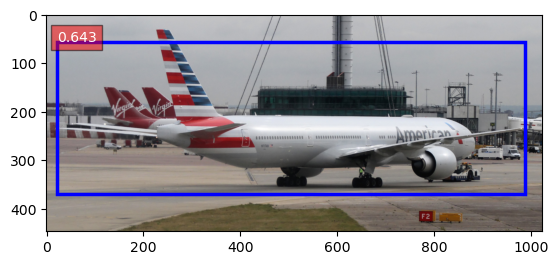

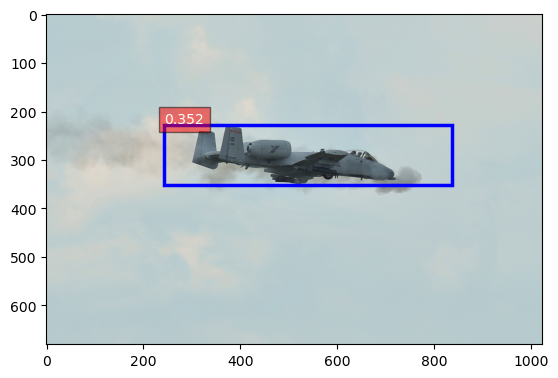

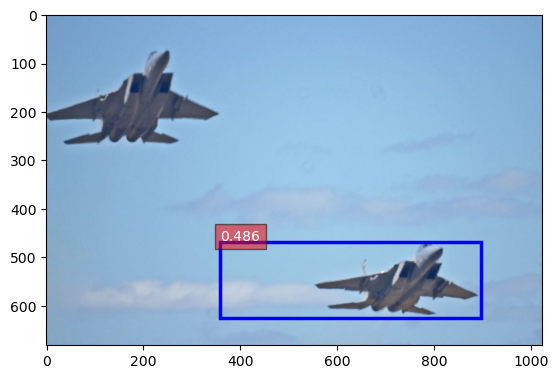

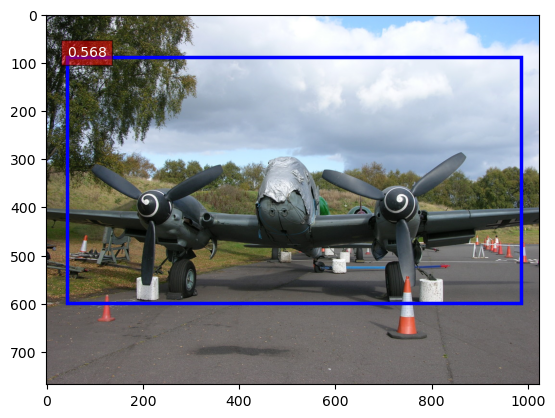

In [66]:
for image in test_images:
    predict_and_show(image, endpoint_name)

### Perform Inference and get the metrics

In [129]:
# Function to get predictions from our new model
import json
import pandas as pd

def query(endpoint_name, image_file_name):
    with open(image_file_name, "rb") as file:
        input_img_rb = bytearray(file.read())

    response = runtime.invoke_endpoint(
        EndpointName=endpoint_name, 
        ContentType="image/jpeg", 
        Body=input_img_rb
    )
    
    return response["Body"].read()

def parse_response_multiple(query_response, threshold=0.2):
    model_predictions = json.loads(query_response)
    
    predictions = model_predictions["prediction"]
    
    valid_predictions = [pred for pred in predictions if pred[1] >= threshold]
    
    if not valid_predictions:
        return [], [], []
    
    selected_boxes = [[pred[2], pred[3], pred[4], pred[5]] for pred in valid_predictions]
    selected_classes = ["airplane" for _ in valid_predictions]
    selected_scores = [pred[1] for pred in valid_predictions]
    
    return selected_boxes, selected_classes, selected_scores


def generate_results_dataframe_multiple(image_paths, endpoint_name, threshold=0.2):
    results = []

    for image_path in image_paths:
        query_response = query(endpoint_name, image_path)
        normalized_boxes, classes_names, confidences = parse_response_multiple(query_response, threshold)
        
        if not normalized_boxes:
            result = {
                'image_path': image_path,
                'normalized_boxes': [],
                'classes_names': [],
                'confidences': []
            }
            results.append(result)
        else:
            for box, class_name, confidence in zip(normalized_boxes, classes_names, confidences):
                result = {
                    'image_path': image_path,
                    'normalized_boxes': [box],  
                    'classes_names': [class_name],  
                    'confidences': [confidence]  
                }
                results.append(result)

    df_results = pd.DataFrame(results)
    return df_results

In [130]:
inference_validation_list = glob.glob('airplane_detection/images/airplanes/images/validation/*.jpg')

df_results = generate_results_dataframe_multiple(inference_validation_list, endpoint_name)

In [132]:
# Saving results

df_results.to_csv("data/benchmarking_results/mxnet_resnet_results.csv")